<h1><b>Import Libraries<b><h1>

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import pandas_datareader as pdr
import tensorflow
import keras
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import time
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.svm import SVR, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

<h1><b>Input Data from Yahoo Finance<b><h1>

In [3]:
import yfinance as yf

ticker = 'LT.NS'
start_date = '2022-01-01'
end_date = '2024-02-02'

DF = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
DF

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747070,1643920
2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123
...,...,...,...,...,...,...
2024-01-25,3599.899902,3618.250000,3564.800049,3593.449951,3593.449951,2206540
2024-01-29,3604.000000,3733.850098,3600.100098,3708.000000,3708.000000,2072982
2024-01-30,3715.949951,3737.899902,3624.899902,3633.300049,3633.300049,1454989


<h1><b>Plotting Graphs price for every day<b><h1>

Text(0, 0.5, 'Value')

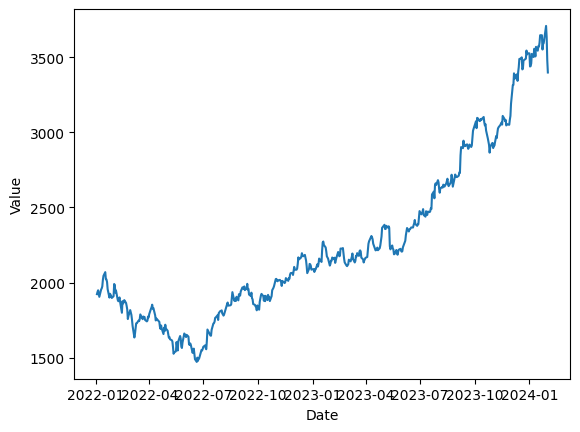

In [189]:
plt.plot(DF.Close)

plt.xlabel('Date')
plt.ylabel('Value')

<h1><b>Define Function<b></h1>

In [190]:
#creating datasets from the dataframe, make data stationary:
def difference_pct_back(datafile, lag = 1):
    diff = [0] * lag
    for i in range(lag,len(datafile)):
        diff.append(datafile[i]/datafile[i-lag]-1)
    return diff

def create_dataset_percentage_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1))
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]/dataset[i+window_size-1,0]-1
        data_Y.append(b)
        i += gap

    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

def create_dataset_difference_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1))
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]-dataset[i+window_size-1,0]
        data_Y.append(b)
        i += gap

    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

#regression to classification:
def y_classifier(array, threshold):
    classes = []
    for i in range(len(array)):
        if array[i,0] > threshold:
            classes.append(1)
        elif array[i,0] < -1*threshold:
            classes.append(-1)
        else:
            classes.append(0)
    return np.asarray(classes)

#defining moving averages:
def EMA(df, EMA_days):
    sma = np.mean(df[0:EMA_days])
    EMA_list = [0] * (EMA_days - 1)
    EMA_list.append(sma)
    c = 2/(1+EMA_days)
    for i in range(EMA_days,len(df)):
        a = EMA_list[i-1]*(1-c)+ c*df[i]
        EMA_list.append(a)
    return(EMA_list)

def SMA(df, sma_days):
    sma_list = [0] * (sma_days - 1)
    for i in range(sma_days, len(df)+1):
        sma_list.append(np.mean(df[i-sma_days:i]))
    return(sma_list)

#defining some metrics
def rms(y, pred):
    temp = 0
    if len(y) != len(pred):
        return False
    else:
        for i in range(len(y)):
            temp += (y[i][0] - pred[i][0])**2
        return temp/len(y)

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)+0.0000000001))

def mae(A, F):
    return 1/len(A) * np.sum(np.abs(F - A))

#autocorrelation benchmark:
def benchmark(y, look_forward):
    Y_hat = []
    Y_real = []
    for i in range(2*look_forward, len(y)):
        a = np.mean(y[i-2*look_forward:i-look_forward,0])
        Y_hat.append(a)
        Y_real.append(y[i,0])
    return (np.asarray(Y_real), np.asarray(Y_hat))

def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

def plot(y_train, prediction_train,y_test, prediction_test):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, prediction_train)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Train')


    plt.subplot(1, 2, 2)
    plt.scatter(y_test, prediction_test)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Test')
    plt.show()

    plt.figure(figsize=(15,8))
    plt.subplot(2, 1, 1)
    plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
    plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
    plt.grid()
    plt.legend()
    plt.title('Train')
    plt.subplots_adjust(hspace = 0.4)

    plt.subplot(2, 1, 2)
    plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
    plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
    plt.grid()
    plt.legend()
    plt.title('Test')

#this function changes 1D y array to an array with 3 features that is used for softmax
def y_softmax(array):
    lst = []
    for i in range(len(array)):
        if array[i] == 1:
            lst.append([1,0,0])
        elif array[i] == 0:
            lst.append([0,1,0])
        else:
            lst.append([0,0,1])
    return np.asarray(lst)


def softmaxifier(array):
    zeros = [0, 0, 0]
    pred = []
    for i in range(len(array)):
        j = np.argmax(array[i])
        temp = [0,0,0]
        temp[j] = 1
        pred.append(temp)
    return pred

#this function changes 3D y array with 3 features that was generated by softmax to an 1D array for confusion matrix
def desoftmaxer(array):
    lst = []
    for i in range(len(array)):
        if np.argmax(array[i]) == 0:
            lst.append(1)
        elif np.argmax(array[i]) == 1:
            lst.append(0)
        else:
            lst.append(-1)
    return (np.asarray(lst))
#fix random effect
def fix_rnd_Keras():
    seed_value= 0
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    import random
    random.seed(seed_value)
    import numpy as np
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.set_random_seed(seed_value)
    from keras import backend as K
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

#split x and y to test and train that are devisible to batch_size
def test_train_split(x, y, batch_size, train_ratio):
    train_length = int(len(x)*train_ratio)
    for i in range(train_length, train_length+batch_size):
        remainder = i%batch_size
        if remainder == 0:
            train_length = i
            break
    x_train = x[:train_length,:]
    y_train = y[:train_length]

    for i in range(len(x)-batch_size, len(x)):
        remainder = i%batch_size
        if remainder == 0:
            train_length_test = i
            break
    x_test = x[train_length:train_length_test,:]
    y_test = y[train_length:train_length_test]
    return x_train, y_train, x_test, y_test

<h1><b>Creating Features<b></h1>

In [193]:
df = DF.Close
df = df.dropna(axis=0, how='any')

#making moving averages
v_10 = SMA(DF.Volume, 10)
v_20 = SMA(DF.Volume, 20)
open_close = (DF.Close/DF.Open - 1).tolist()
high_low = (DF.High/DF.Low - 1).tolist()
EMA_8 = EMA(df,8)
SMA_10 = SMA(df,10)
SMA_20 = SMA(df,20)
SMA_50 = SMA(df,50)
SMA_100 = SMA(df,100)
pct_day = difference_pct_back(df, 1)
list_df = df.tolist()
vol_list = DF.Volume.tolist()
MAs = pd.DataFrame(list(zip(list_df, pct_day, vol_list, v_10, v_20,open_close,high_low, EMA_8, SMA_10,
                            SMA_20, SMA_50, SMA_100)),columns=['spot', 'pct_day', 'vol', 'v_10', 'v_20',
                            'open_close', 'high_low', 'EMA_8', 'SMA_10', 'SMA_20', 'SMA_50','SMA_100'])

#removing all rows with 0 in them
MAs = MAs[100:]
MAs = MAs.reset_index(drop=True)

#making differences as features
MAs['v10'] = MAs.vol/MAs.v_10 - 1
MAs['v20'] = MAs.vol/MAs.v_20 - 1
MAs['spot_EMA'] = MAs.spot/MAs.EMA_8 - 1
MAs['spot_20SMA'] = MAs.spot/MAs.SMA_20 - 1
MAs['spot_50SMA'] = MAs.spot/MAs.SMA_50 - 1
MAs['spot_100SMA'] = MAs.spot/MAs.SMA_100 - 1
MAs['10_100_SMA'] = MAs.SMA_10/MAs.SMA_100 - 1
MAs['20_50_SMA'] = MAs.SMA_20/MAs.SMA_50 - 1
MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)

TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

<h1><b>Visualisation<b></h1>

,spot,pct_day,vol,v_10,v_20,open_close,high_low,EMA_8,SMA_10,SMA_20,SMA_50,SMA_100,v10,v20,spot_EMA,spot_20SMA,spot_50SMA,spot_100SMA,10_100_SMA,20_50_SMA
0,1654.500000,-0.003823,3534742,2503540.8,2332292.15,-0.003613,0.017872,1617.662209,1605.595007,1597.627502,1690.290002,1781.755498,0.411897,0.515566,0.022772,0.035598,-0.021174,-0.071421,-0.098869,-0.054820
1,1648.000000,-0.003929,1425466,2347686.5,2314681.80,-0.003356,0.013763,1624.403940,1613.145007,1598.330005,1687.492002,1778.859998,-0.392821,-0.384163,0.014526,0.031076,-0.023403,-0.073564,-0.093158,-0.052837
2,1637.150024,-0.006584,1852251,2353027.3,2321906.75,0.003156,0.015859,1627.236403,1622.065015,1598.305005,1685.109001,1775.745498,-0.212822,-0.202272,0.006092,0.024304,-0.028460,-0.078049,-0.086544,-0.051512
3,1652.050049,0.009101,2928263,2428331.2,2396343.90,-0.003559,0.017478,1632.750547,1626.260022,1599.785010,1682.669001,1773.020999,0.205875,0.221971,0.011820,0.032670,-0.018197,-0.068229,-0.082775,-0.049257
4,1640.199951,-0.007173,1538005,2164350.6,2403243.65,-0.007233,0.017257,1634.405970,1625.865015,1600.987506,1680.128000,1770.373998,-0.289392,-0.360030,0.003545,0.024493,-0.023765,-0.073529,-0.081626,-0.047104


<Figure size 640x480 with 0 Axes>

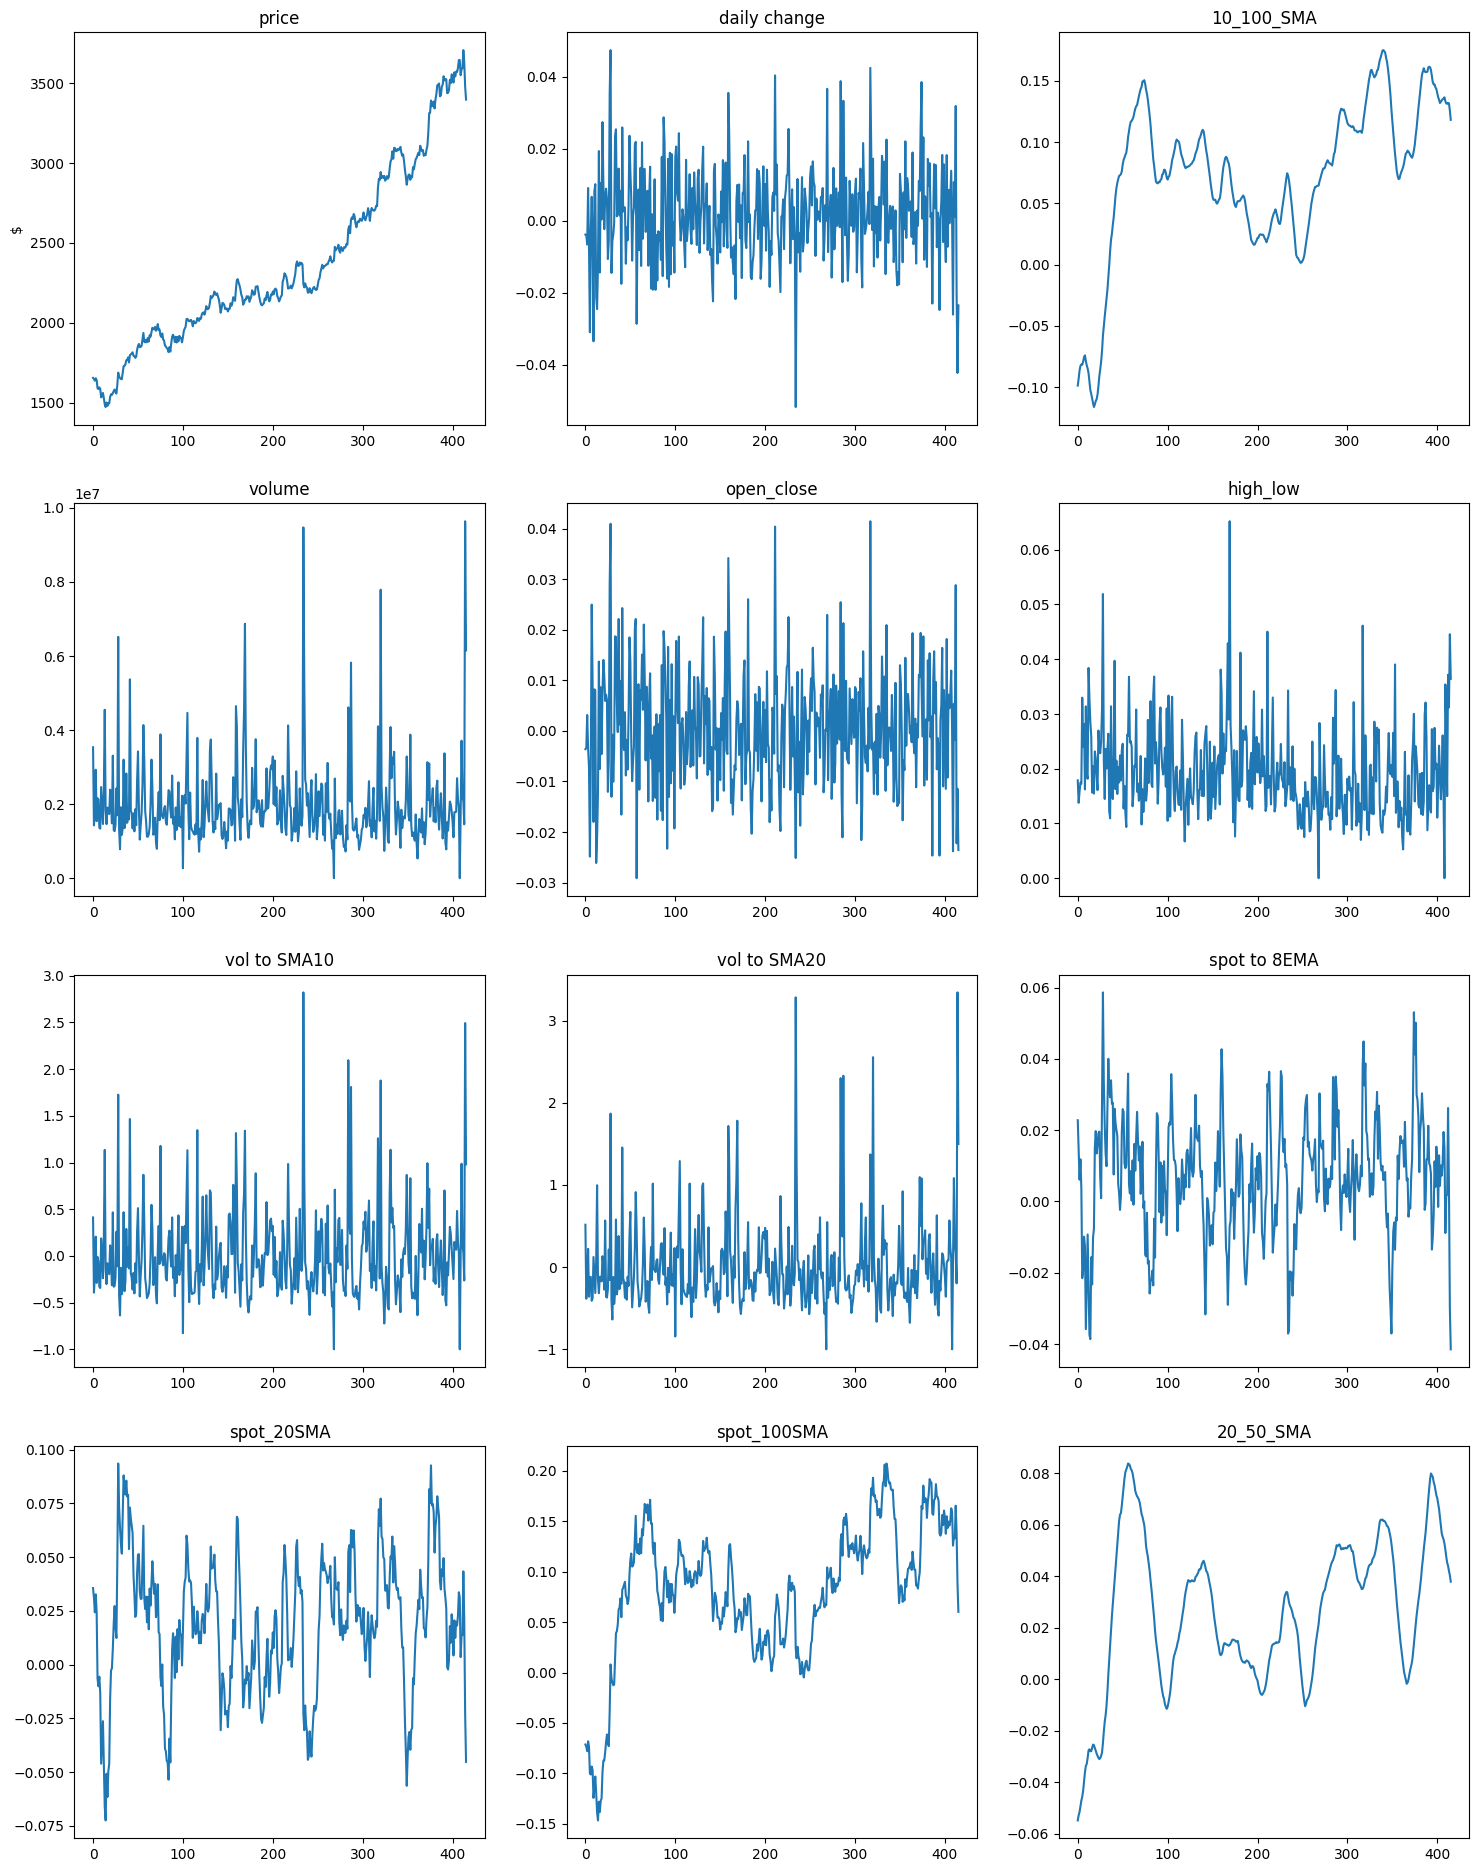

In [194]:
fig = plt.figure()
plt.figure(figsize=(18,14))

plt.subplot(4, 3, 1)
plt.plot(MAs.spot)
plt.ylabel('$')
plt.title('price')

plt.subplot(4, 3, 2)
plt.plot(MAs.pct_day)
plt.title('daily change')

plt.subplot(4, 3, 3)
plt.plot(MAs['10_100_SMA'])
plt.title('10_100_SMA')

plt.subplot(4, 3, 4)
plt.plot(MAs.vol)
plt.title('volume')
plt.subplots_adjust(top = 1.4)

plt.subplot(4, 3, 5)
plt.plot(MAs.open_close)
plt.title('open_close')

plt.subplot(4, 3, 6)
plt.plot(MAs.high_low)
plt.title('high_low')

plt.subplot(4, 3, 7)
plt.plot(MAs.v10)
plt.title('vol to SMA10')

plt.subplot(4, 3, 8)
plt.plot(MAs.v20)
plt.title('vol to SMA20')

plt.subplot(4, 3, 9)
plt.plot(MAs.spot_EMA)
plt.title('spot to 8EMA')

plt.subplot(4, 3, 10)
plt.plot(MAs.spot_20SMA)
plt.title('spot_20SMA')

plt.subplot(4, 3, 11)
plt.plot(MAs.spot_100SMA)
plt.title('spot_100SMA')

plt.subplot(4, 3, 12)
plt.plot(MAs['20_50_SMA'])
plt.title('20_50_SMA')
MAs.head(5)

<h1><b>Opening Price Prediction<b><h1>

In [195]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as web
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [196]:
import yfinance as yf
import datetime

ticker = 'LT.NS'
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2024, 2, 2)

df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [197]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747070,1643920
2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123
...,...,...,...,...,...,...
2024-01-25,3599.899902,3618.250000,3564.800049,3593.449951,3593.449951,2206540
2024-01-29,3604.000000,3733.850098,3600.100098,3708.000000,3708.000000,2072982
2024-01-30,3715.949951,3737.899902,3624.899902,3633.300049,3633.300049,1454989


In [198]:
df.shape

(516, 6)

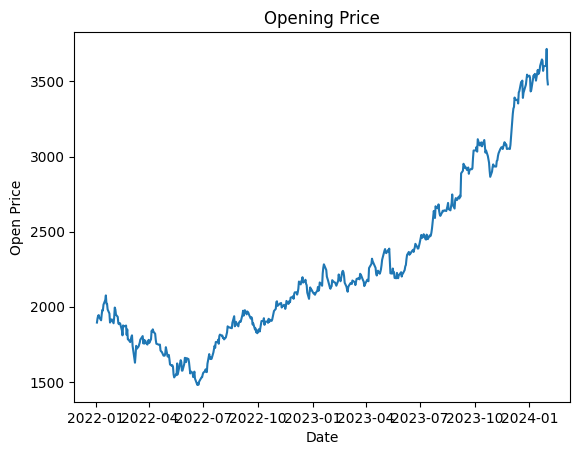

In [199]:
plt.figure()
plt.title('Opening Price')
plt.plot(df['Open'])
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.show()

In [200]:
data=df.filter(['Open'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on
#math.ceil to round up

training_data_len = math.ceil(len(dataset)*.8)

#print(dataset)
training_data_len

413

In [201]:
#Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [202]:
#Create training dataset
#Create scaled training dataset

train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set

x_train=[]
y_train=[]

for i in range(80, len(train_data)):
    x_train.append(train_data[i-80:i,0])
    y_train.append(train_data[i,0])
    if i<=80:
        print(x_train)
        print(y_train)
        print()

[array([0.18560344, 0.19805898, 0.20604216, 0.20774168, 0.20083189,
       0.192312  , 0.20975425, 0.22294775, 0.22162842, 0.23882467,
       0.25257721, 0.2663968 , 0.24146338, 0.24150809, 0.22458017,
       0.21243767, 0.18560344, 0.19434695, 0.19504013, 0.18345668,
       0.20065298, 0.23037187, 0.22428946, 0.20930701, 0.20237483,
       0.18336725, 0.18090745, 0.18426173, 0.18292002, 0.16245891,
       0.14758828, 0.17712832, 0.17397527, 0.17442251, 0.17663631,
       0.14892999, 0.16503053, 0.13562468, 0.13506564, 0.12741789,
       0.1431159 , 0.14758828, 0.11628167, 0.07972003, 0.06614639,
       0.08788211, 0.11628167, 0.10733693, 0.11404549, 0.11985957,
       0.12567365, 0.13468549, 0.14535209, 0.12357166, 0.13417116,
       0.12299023, 0.13220331, 0.12164852, 0.12017261, 0.12831236,
       0.13414878, 0.12477918, 0.13596011, 0.16100539, 0.15787473,
       0.16543305, 0.15894811, 0.15217246, 0.13417116, 0.12263242,
       0.11909929, 0.11999376, 0.10284217, 0.09971151, 0.0988

In [203]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [204]:
#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(333, 80, 1)

<h1><b>Model Training<b></h1>

In [205]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1],1)))
#Add second layer to model
model.add(LSTM(100, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(50))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

In [206]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [207]:
#Train the model
model.fit(x_train, y_train, batch_size=1,epochs=50)

Epoch 1/50


333/333 [==============================] - 7s 16ms/step - loss: 0.0020
Epoch 2/50
333/333 [==============================] - 5s 16ms/step - loss: 0.0011
Epoch 3/50
333/333 [==============================] - 5s 16ms/step - loss: 8.1842e-04
Epoch 4/50
333/333 [==============================] - 5s 16ms/step - loss: 6.1547e-04
Epoch 5/50
333/333 [==============================] - 5s 15ms/step - loss: 5.3559e-04
Epoch 6/50
333/333 [==============================] - 5s 15ms/step - loss: 5.4501e-04
Epoch 7/50
333/333 [==============================] - 5s 15ms/step - loss: 4.1456e-04
Epoch 8/50
333/333 [==============================] - 5s 15ms/step - loss: 3.7458e-04
Epoch 9/50
333/333 [==============================] - 5s 15ms/step - loss: 4.0095e-04
Epoch 10/50
333/333 [==============================] - 5s 15ms/step - loss: 4.6102e-04
Epoch 11/50
333/333 [==============================] - 5s 15ms/step - loss: 4.6134e-04
Epoch 12/50
333/333 [==============================] - 5s 15ms/step - l

<h1><b>Testing and Validating Model<b><h1>

In [208]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-80: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(80, len(test_data)):
    x_test.append(test_data[i-80:i,0])

In [209]:
#Convert the data to a numpy array

x_test=np.array(x_test)

In [210]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [211]:
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

4/4 [==============================] - 1s 19ms/step


In [212]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse =np.sqrt(np.mean(predictions-y_test)**2)



print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
mape = mean_absolute_percentage_error(y_test, predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Squared Error: 13497.267928743826
Mean Absolute Error: 106.30472542475728
Root Mean Squared Error: 103.61782273968447
Mean Absolute Percentage Error (MAPE): 3.362067633582004


C:\Users\soham\AppData\Local\Temp\ipykernel_25396\22111314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


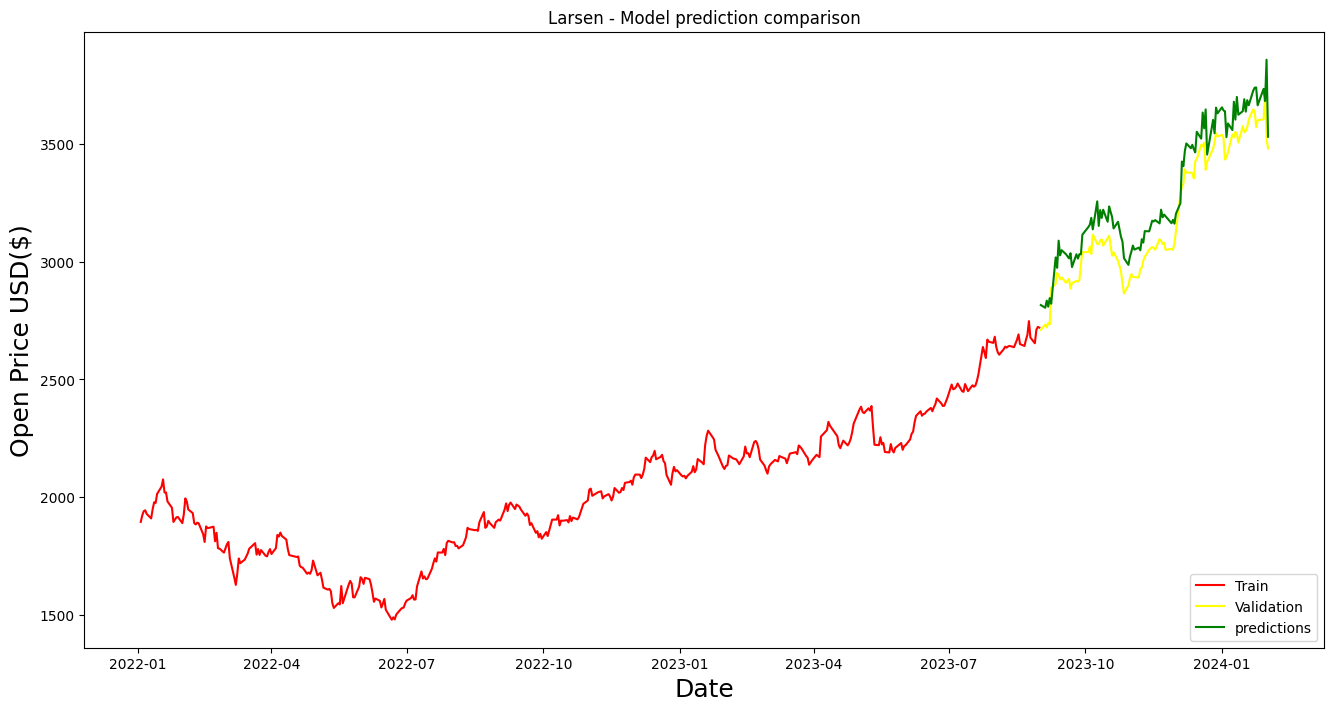

In [213]:
#plot the data

train=data[:training_data_len]
valid=data[training_data_len:]
valid['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Larsen - Model prediction comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD($)', fontsize=18)
plt.plot(train['Open'] , color='red')
plt.plot(valid['Open'] , color='yellow')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'predictions'], loc='lower right')
plt.show()

In [214]:
#Show the valid and predicted prices

valid.tail(30)

,Open,predictions
Date,,
2023-12-20,3505.000000,3565.785645
2023-12-21,3390.050049,3645.928955
2023-12-22,3424.000000,3454.210938
2023-12-26,3477.949951,3601.668213
2023-12-27,3510.000000,3544.910156
2023-12-28,3545.000000,3653.374268
2023-12-29,3531.000000,3629.378906
2024-01-01,3538.000000,3654.919434
2024-01-02,3525.050049,3641.621338


<h1><b>Getting Predictions for Tomorrow<b></h1>

In [215]:
#Get the quote
ticker = 'LT.NS'
start_date = '2022-01-01'
end_date = '2024-02-02'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

new_df=stock_quote.filter(['Open'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Opening Price of {ticker} tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 1s 511ms/step
Opening Price of LT.NS tomorrow:[[3694.0051]]


<h1><b>Getting Predictions for 60 days from now<b></h1>

In [216]:
import yfinance as yf
import numpy as np

# Assuming you already have the 'model' and 'scaler' objects defined

# Get historical stock data
ticker = 'LT.NS'
start_date = '2022-01-01'
end_date = '2024-02-02'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

# Extract 'Open' prices
new_df = stock_quote.filter(['Open'])

# Take the last 60 days of 'Open' prices and scale them
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list to store predicted prices
predicted_prices = []

# Number of days to forecast (adjust as needed)
forecast_days = 60

# Loop through the forecast period
for _ in range(forecast_days):
    # Reshape the data for prediction
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Get predicted scaled price
    pred_price = model.predict(X_test)

    # Undo the scaling
    pred_price = scaler.inverse_transform(pred_price)

    # Append the predicted price to the list
    predicted_prices.append(pred_price[0, 0])

    # Update last_60_days for the next iteration
    last_60_days = np.append(last_60_days[1:], pred_price, axis=0)
    last_60_days_scaled = scaler.transform(last_60_days)

# Print the predicted prices for the next 2 months
for i, price in enumerate(predicted_prices, 1):
    print(f'Day {i}: Predicted Opening Price of {ticker}: {price}')


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 21ms/step
Day 1: Predicted Opening Price of LT.NS: 3694.005126953125
Day 2: Predicted Opening Price of LT.NS: 3766.353759765625
Day 3: Predicted Opening Price of LT.NS: 3863.4111328125
Day 4: Predicted Opening Price of LT.NS: 3946.868896484375
Day 5: Predicted Opening Price of LT.NS: 4018.52392578125
Day 6: Predicted Opening Price of LT.NS: 4074.966796875
Day 7: Predicted Opening Price of LT.NS: 4117.60302734375
Day 8: Predicted Opening Price of LT.NS: 4148.6513671875
Day 9: Predicted Opening Price of LT.NS: 4171.03759765625
Day 10: Predicted Opening Price of LT.NS: 4187.501953125
Day 11: Predicted Opening Price of LT.NS: 4200.29443359375
Day 12: Predicted Opening Price of LT.NS: 4211.01611328125
Day 13: Predicted Opening Price of LT.NS: 4220.64990234375
Day 14: Predicted Opening Price of LT.NS: 4229.6806640625
Day 15: Predicted Opening Price of LT.NS: 4238.24072265625
Day 16:

<h1><b>Closing Price Prediction<b></h1>

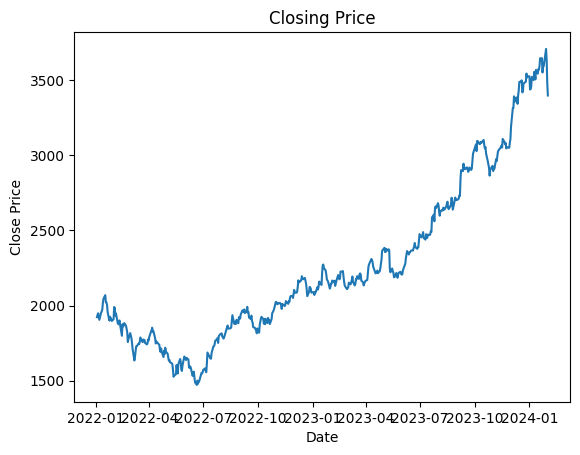

In [217]:
plt.figure()
plt.title('Closing Price')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [218]:
data=df.filter(['Close'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on
#math.ceil to round up

training_data_len = math.ceil(len(dataset)*.8)

#print(dataset)
training_data_len

413

In [219]:
data

,Close
Date,
2022-01-03,1922.849976
2022-01-04,1937.550049
2022-01-05,1948.599976
2022-01-06,1924.500000
2022-01-07,1904.900024
...,...
2024-01-25,3593.449951
2024-01-29,3708.000000
2024-01-30,3633.300049


In [220]:
#Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [221]:
#Create training dataset
#Create scaled training dataset

train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set

x_train=[]
y_train=[]

for i in range(80, len(train_data)):
    x_train.append(train_data[i-80:i,0])
    y_train.append(train_data[i,0])
    if i<=80:
        print(x_train)
        print(y_train)
        print()

[array([0.20170375, 0.20827744, 0.21321883, 0.20244162, 0.19367677,
       0.21523117, 0.21883105, 0.22466681, 0.24443251, 0.25621589,
       0.26723901, 0.24613179, 0.24555048, 0.23776941, 0.2165504 ,
       0.19144083, 0.2027994 , 0.19633751, 0.19038995, 0.19559964,
       0.23195598, 0.2284679 , 0.2065334 , 0.21292814, 0.18455414,
       0.18057416, 0.18647706, 0.19193273, 0.17862891, 0.14631963,
       0.18077543, 0.17391106, 0.17748856, 0.18392806, 0.17536442,
       0.16664427, 0.15584474, 0.12769427, 0.13650389, 0.1542572 ,
       0.13983542, 0.12543601, 0.10730255, 0.07273495, 0.08348983,
       0.09800103, 0.11465876, 0.11486002, 0.1229541 , 0.12147836,
       0.12718   , 0.14135586, 0.12722476, 0.13516233, 0.13212144,
       0.13404436, 0.12489935, 0.12065107, 0.12290939, 0.13496106,
       0.13230032, 0.14233965, 0.15855019, 0.16288794, 0.17037832,
       0.15852786, 0.16051782, 0.13849385, 0.12337891, 0.1292371 ,
       0.11919772, 0.10461942, 0.09829171, 0.10853231, 0.0995

In [222]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [223]:
#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(333, 80, 1)

<h1><b>Model Training<b></h1>

In [224]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1],1)))
#Add second layer to model
model.add(LSTM(100, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(50))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

In [225]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [226]:
#Train the model
model.fit(x_train, y_train, batch_size=1,epochs=50)

Epoch 1/50
333/333 [==============================] - 8s 15ms/step - loss: 0.0021
Epoch 2/50
333/333 [==============================] - 5s 15ms/step - loss: 0.0014
Epoch 3/50
333/333 [==============================] - 5s 15ms/step - loss: 7.4095e-04
Epoch 4/50
333/333 [==============================] - 5s 15ms/step - loss: 6.0042e-04
Epoch 5/50
333/333 [==============================] - 5s 15ms/step - loss: 5.7407e-04
Epoch 6/50
333/333 [==============================] - 5s 15ms/step - loss: 4.2712e-04
Epoch 7/50
333/333 [==============================] - 5s 15ms/step - loss: 4.4003e-04
Epoch 8/50
333/333 [==============================] - 5s 15ms/step - loss: 3.8475e-04
Epoch 9/50
333/333 [==============================] - 5s 15ms/step - loss: 3.5196e-04
Epoch 10/50
333/333 [==============================] - 5s 15ms/step - loss: 4.7179e-04
Epoch 11/50
333/333 [==============================] - 5s 15ms/step - loss: 4.2134e-04
Epoch 12/50
333/333 [==============================] - 5s 15

<h1><b>Testing and Validating Model<b></h1>

In [227]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-80: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(80, len(test_data)):
    x_test.append(test_data[i-80:i,0])

In [228]:
#Convert the data to a numpy array

x_test=np.array(x_test)

In [229]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [230]:
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

4/4 [==============================] - 1s 18ms/step


In [231]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse =np.sqrt(np.mean(predictions-y_test)**2)



print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
mape = mean_absolute_percentage_error(y_test, predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Squared Error: 2915.243298887049
Mean Absolute Error: 45.538299264259706
Root Mean Squared Error: 23.71975500606796
Mean Absolute Percentage Error (MAPE): 1.4419397580155529


C:\Users\soham\AppData\Local\Temp\ipykernel_25396\1882318240.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


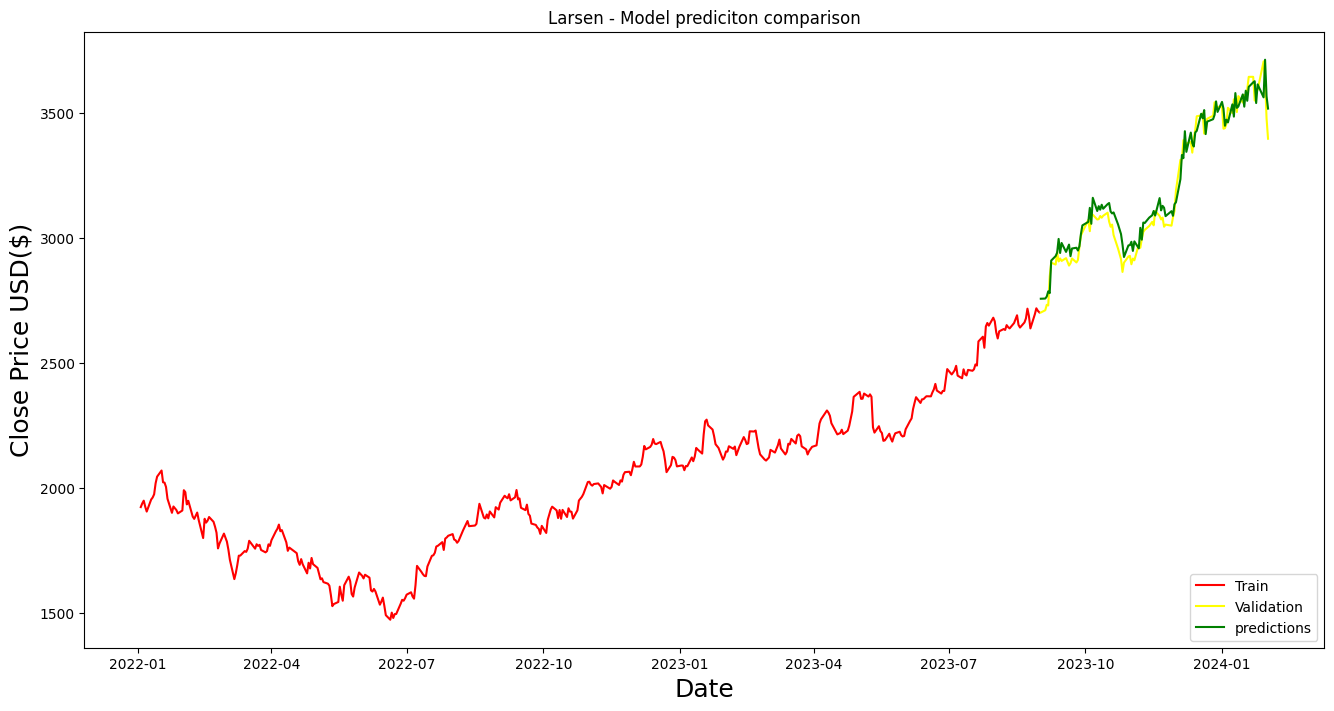

In [232]:
#plot the data

train=data[:training_data_len]
valid=data[training_data_len:]
valid['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Larsen - Model prediciton comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Close'] , color='red')
plt.plot(valid['Close'] , color='yellow')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'predictions'], loc='lower right')
plt.show()

In [233]:
#Show the valid and predicted prices

valid.tail(30)

,Close,predictions
Date,,
2023-12-20,3418.500000,3512.711182
2023-12-21,3424.149902,3416.708740
2023-12-22,3477.949951,3466.472900
2023-12-26,3490.050049,3476.257812
2023-12-27,3544.000000,3493.685303
2023-12-28,3518.050049,3547.617920
2023-12-29,3526.000000,3505.464111
2024-01-01,3525.449951,3545.557129
2024-01-02,3438.100098,3518.597168


<h1><b>Getting Predictions for Tomorrow<b></h1>

In [234]:
#Get the quote
ticker = 'LT.NS'
start_date = '2022-01-01'
end_date = '2024-02-02'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

new_df=stock_quote.filter(['Open'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Opening Price of {ticker} tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 489ms/step
Opening Price of LT.NS tomorrow:[[3562.5178]]


<h1><b>Getting Predictions for 60 days from now<b></h1>

In [235]:
import yfinance as yf
import numpy as np

# Assuming you already have the 'model' and 'scaler' objects defined

# Get historical stock data
ticker = 'LT.NS'
start_date = '2022-01-01'
end_date = '2024-02-02'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

# Extract 'Open' prices
new_df = stock_quote.filter(['Open'])

# Take the last 60 days of 'Open' prices and scale them
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list to store predicted prices
predicted_prices = []

# Number of days to forecast (adjust as needed)
forecast_days = 60

# Loop through the forecast period
for _ in range(forecast_days):
    # Reshape the data for prediction
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Get predicted scaled price
    pred_price = model.predict(X_test)

    # Undo the scaling
    pred_price = scaler.inverse_transform(pred_price)

    # Append the predicted price to the list
    predicted_prices.append(pred_price[0, 0])

    # Update last_60_days for the next iteration
    last_60_days = np.append(last_60_days[1:], pred_price, axis=0)
    last_60_days_scaled = scaler.transform(last_60_days)

# Print the predicted prices for the next 2 months
for i, price in enumerate(predicted_prices, 1):
    print(f'Day {i}: Predicted Opening Price of {ticker}: {price}')


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 20ms/step
Day 1: Predicted Opening Price of LT.NS: 3562.517822265625
Day 2: Predicted Opening Price of LT.NS: 3540.374755859375
Day 3: Predicted Opening Price of LT.NS: 3542.11767578125
Day 4: Predicted Opening Price of LT.NS: 3547.0693359375
Day 5: Predicted Opening Price of LT.NS: 3550.50244140625
Day 6: Predicted Opening Price of LT.NS: 3554.621826171875
Day 7: Predicted Opening Price of LT.NS: 3558.097412109375
Day 8: Predicted Opening Price of LT.NS: 3560.812255859375
Day 9: Predicted Opening Price of LT.NS: 3562.770751953125
Day 10: Predicted Opening Price of LT.NS: 3564.05078125
Day 11: Predicted Opening Price of LT.NS: 3564.808349609375
Day 12: Predicted Opening Price of LT.NS: 3565.2041015625
Day 13: Predicted Opening Price of LT.NS: 3565.3828125
Day 14: Predicted Opening Price of LT.NS: 3565.4560546875
Day 15: Predicted Opening Price of LT.NS: 3565.501220703125
Day 1